## Machine Learning Assignment 1
### Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)
UCI-ML Dataset Link: https://archive.ics.uci.edu/dataset/379/website+phishing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
import zipfile
import os
from lazypredict.Supervised import LazyClassifier

In [2]:
# Data Loader loads data from UCI-ML Repo
def load_dataset():
    # Download, extract and load Dataset
    flag = False
    dataset_folder = 'website_phishing_data'
    if os.path.exists(dataset_folder):
        files = os.listdir(dataset_folder)
        for file in files:
            if file.endswith(".arff"):
                flag = True
        if flag == False:
            os.rmdir(dataset_folder)

    if flag == False:
        urllib.request.urlretrieve('https://archive.ics.uci.edu/static/public/379/website+phishing.zip', 'website_phishing.zip')
        with zipfile.ZipFile('website_phishing.zip', 'r') as zip_ref:
            zip_ref.extractall('website_phishing_data')
    names = os.listdir(dataset_folder)
    input = ''
    for name in names:
        if name.endswith(".arff"):
            input = name
            break
    
    phishing_data, meta = arff.loadarff(f'{dataset_folder}/{input}')
    phishing_data = pd.DataFrame(phishing_data)

    for column in phishing_data.columns:
        if phishing_data[column].dtype == 'object':  # Only apply to columns with object dtype
            phishing_data[column] = phishing_data[column].str.decode('utf-8')
            phishing_data[column] = phishing_data[column].astype(int)

    # data (as pandas dataframes) 
    x = phishing_data.drop(['Result'], axis=1)
    y = phishing_data[['Result']] 
    z = phishing_data

    # metadata 
    print(meta) 

    return x, y, z

features, targets, original = load_dataset()

Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')



In [3]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(original)

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: Request_URL
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: URL_of_Anchor
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: web_traffic
Column DataType: int32
Column unique values: [ 1  0 -1]
Column has null: False


Column Name: URL_Length
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: age_of_domain
Column DataType: int32
Column unique values: [ 1 -1]
Column has null: False


Column Name: having_IP_Address
Column DataType: int32
Column unique values: [0 1]
Column has null: False


Column Name: Result
Column DataType: int32
Column 

In [4]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

clean_data(original,null_cols,False)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


In [5]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

transform_data(original)

Categorical columns: Index([], dtype='object')
Numerical columns: Index([], dtype='object')


,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1348,-1,-1,-1,-1,-1,-1,0,1,0,1
1349,-1,0,1,0,-1,0,0,1,0,-1
1350,-1,0,-1,-1,-1,0,-1,-1,0,1
1351,0,0,1,0,0,0,-1,1,0,1


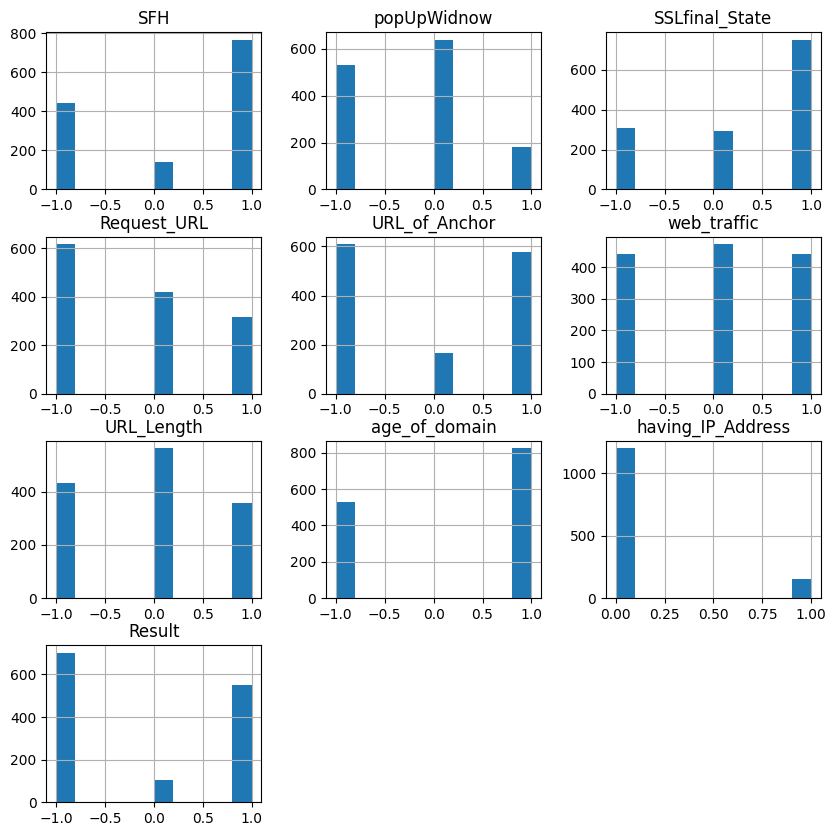

In [6]:
# Creates histograms for categorical data
def plot_histograms(df):
    df.hist(figsize=(10, 10))
    plt.show()

# Creates boxplot for numerical data
def plot_boxplots(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        sns.boxplot(x=df[col])
        plt.show()

plot_histograms(original)
plot_boxplots(original)

In [7]:
def generate_summary_statistics(original):
    """
    Generate summary statistics for a given DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame.

    Returns:
    DataFrame: Summary statistics DataFrame.
    """
    # Compute mean
    mean = original.mean()

    # Compute mode
    mode = original.mode().iloc[0]  # Mode may have multiple values, so we take the first one

    # Compute median
    median = original.median()

    # Compute quartiles
    quartiles = original.quantile([0.25, 0.5, 0.75])

    # Compute minimum and maximum
    minimum = original.min()
    maximum = original.max()

    # Combine the results into a DataFrame for easier visualization
    summary_df = pd.DataFrame({
        'Mean': mean,
        'Mode': mode,
        'Median': median,
        'Q1': quartiles.loc[0.25],
        'Q2': quartiles.loc[0.5],
        'Q3': quartiles.loc[0.75],
        'Minimum': minimum,
        'Maximum': maximum
    })

    return summary_df

In [8]:
# Runs KNNClassifier on default settings
def knn_classifier(df, target_name):
    # Separate features and targets and perform data splitting
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    knn_model = KNeighborsClassifier()
    
    knn_model.fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))

In [9]:
# Runs KNN CV on default settings
def knn_cv(df, target_name, cv=5):

    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]

    # Initialize the KNN classifier
    knn_classifier = KNeighborsClassifier()
    
    # Initialize k-fold cross-validation
    k_fold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Perform cross-validation and compute scores
    scores = cross_val_score(knn_classifier, X, y, cv=k_fold, scoring='accuracy')
    
    # Calculate and print the mean and standard deviation of the scores
    mean_accuracy = scores.mean()
    std_accuracy = scores.std()
    
    print("Cross-Validation Scores:", scores)
    print("Mean Accuracy:", mean_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

In [10]:
def lazy_classifier(df, target_name):
    # Separate features and targets and perform data splitting
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Initialize Lazy Classifier
    clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None, predictions=True)

    # Generate predictions and evaluate performance
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    print("Mean Accuracy of the Dataset: ", models['Accuracy'].mean())
    print("Standard Deviation of Accuracy of the Dataset: ", models['Accuracy'].std())
    
    return models

model = lazy_classifier(original, targets.columns[0])

  3%|▎         | 1/29 [00:00<00:05,  5.54it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 14%|█▍        | 4/29 [00:00<00:04,  6.18it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')


 41%|████▏     | 12/29 [00:01<00:01, 14.17it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')


 52%|█████▏    | 15/29 [00:01<00:00, 16.27it/s]

ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
NuSVC model failed to execute
specified nu is infeasible
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 90%|████████▉ | 26/29 [00:01<00:00, 20.92it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
XGBClassifier model failed to execute
Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the trai

100%|██████████| 29/29 [00:01<00:00, 14.68it/s]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
Mean Accuracy of the Dataset:  0.7969003690036902
Standard Deviation of Accuracy of the Dataset:  0.12835583536311043


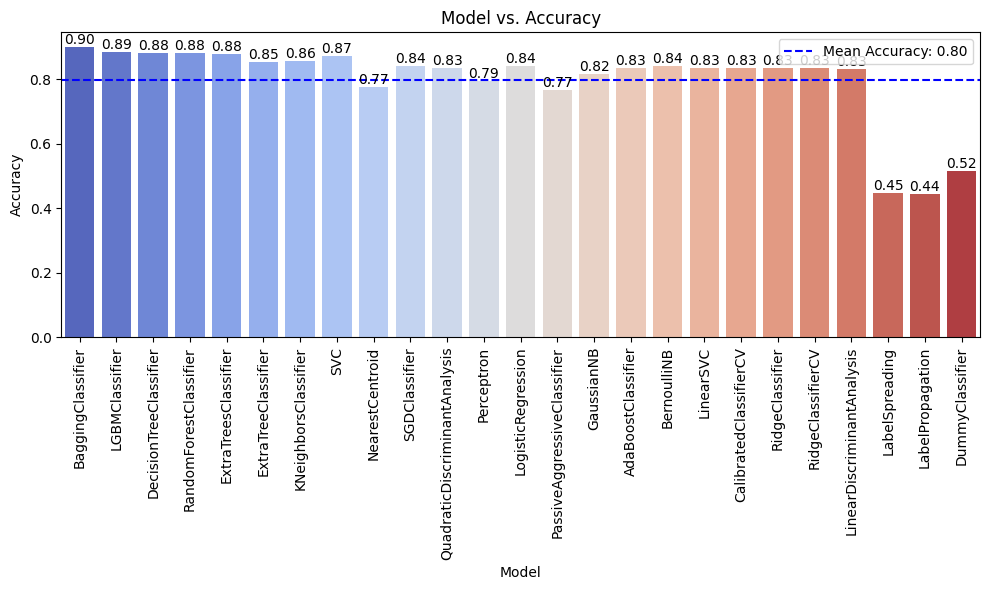

In [11]:
# Plot a model vs Accuracy graph for Lazy Predict
def plot_model_accuracy_graph(df):
    mean_accuracy = df['Accuracy'].mean()
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model', y='Accuracy', data=df, palette='coolwarm')
    plt.axhline(mean_accuracy, color='blue', linestyle='--', label=f'Mean Accuracy: {mean_accuracy:.2f}')
    plt.title('Model vs. Accuracy')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)
    plt.legend()

    for i in range(len(df)):
        plt.text(i, df['Accuracy'][i], f"{df['Accuracy'][i]:.2f}", ha = 'center', va = 'bottom')

    plt.tight_layout()
    plt.show()

plot_model_accuracy_graph(model)

In [12]:
# Master Workflow, combines and manages all the workflow from one place
# Specifically Tailored for Mushroom Dataset
def master_workflow():
    features, targets, original = load_dataset()
    null_cols = null_check(original)
    original = clean_data(original,null_cols,False)
    original = transform_data(original)
    print("Original Summary Statistics: \n", generate_summary_statistics(original))
    plot_histograms(original)
    print("KNN Classifier:")
    knn_classifier(original, targets.columns[0])
    print("Cross-Validation with KNN Classifier:")
    knn_cv(original, targets.columns[0])
    print("Lazy Predict for different models:")
    model = lazy_classifier(original, targets.columns[0])
    plot_model_accuracy_graph(model)

Dataset: 'Phishing-weka.filters.supervised.attribute.AttributeSelection-Eweka.attributeSelection.InfoGainAttributeEval-Sweka.attributeSelection.Ranker
	SFH's type is nominal, range is ('1', '-1', '0')
	popUpWidnow's type is nominal, range is ('-1', '0', '1')
	SSLfinal_State's type is nominal, range is ('1', '-1', '0')
	Request_URL's type is nominal, range is ('-1', '0', '1')
	URL_of_Anchor's type is nominal, range is ('-1', '0', '1')
	web_traffic's type is nominal, range is ('1', '0', '-1')
	URL_Length's type is nominal, range is ('1', '-1', '0')
	age_of_domain's type is nominal, range is ('1', '-1')
	having_IP_Address's type is nominal, range is ('0', '1')
	Result's type is nominal, range is ('0', '1', '-1')

Column Name: SFH
Column DataType: int32
Column unique values: [ 1 -1  0]
Column has null: False


Column Name: popUpWidnow
Column DataType: int32
Column unique values: [-1  0  1]
Column has null: False


Column Name: SSLfinal_State
Column DataType: int32
Column unique values: [ 1

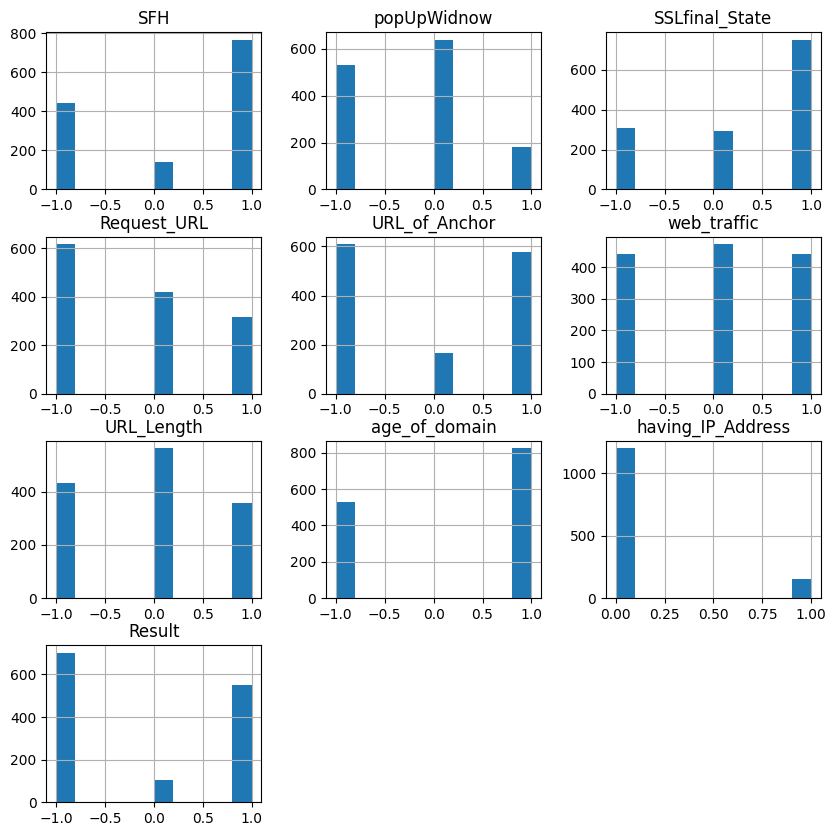

KNN Classifier:
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90       140
           0       0.77      0.48      0.59        21
           1       0.85      0.91      0.88       110

    accuracy                           0.87       271
   macro avg       0.84      0.76      0.79       271
weighted avg       0.87      0.87      0.87       271

Accuracy: 0.8708487084870848
Cross-Validation with KNN Classifier:
Cross-Validation Scores: [0.83763838 0.86715867 0.87453875 0.87037037 0.87777778]
Mean Accuracy: 0.8654967883012162
Standard Deviation of Accuracy: 0.014388776621204719
Lazy Predict for different models:


  3%|▎         | 1/29 [00:00<00:04,  6.47it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')


 14%|█▍        | 4/29 [00:00<00:03,  7.64it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for ExtraTreeClassifier
multi_class must be in ('ovo', 'ovr')


 41%|████▏     | 12/29 [00:00<00:01, 13.81it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')


 55%|█████▌    | 16/29 [00:01<00:00, 15.07it/s]

ROC AUC couldn't be calculated for LabelSpreading
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
NuSVC model failed to execute
specified nu is infeasible
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for Perceptron
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
multi_class must be in ('ovo', 'ovr')


 90%|████████▉ | 26/29 [00:01<00:00, 20.07it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
ROC AUC couldn't be calculated for SVC
multi_class must be in ('ovo', 'ovr')
StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
XGBClassifier model failed to execute
Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1  0  1]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the trai

100%|██████████| 29/29 [00:02<00:00, 14.39it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
Mean Accuracy of the Dataset:  0.7969003690036902
Standard Deviation of Accuracy of the Dataset:  0.12835583536311043


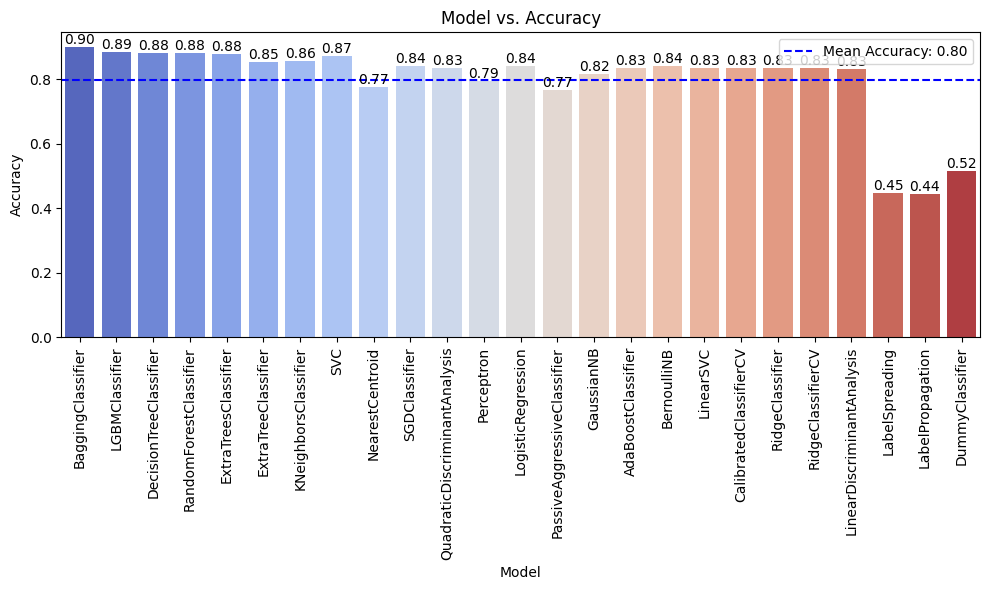

In [13]:
master_workflow()

### EDA Interpretation

Interpretation of EDA:
- Analysis of feature distributions and relationships showed that all the features were categorical with only 3 possible classes.
- The dataset does not contain any Null values.


### ML Results Interpretation

Interpretation of ML Results:
- KNN was applied to the dataset, the accuracy of the model was 0.871.
- KNN with cross-validation was also applied to the dataset, the mean accuracy was 0.865 with a standard deviation of 0.014
- Additionally we also applied Lazy Predict on the dataset, the mean accuracy of the models was 0.797 with a standard deviation of 0.128
- It was observed that the model performed poorly with Cross Validation in comparision.
- The model performance suggests that the model has a data with related features, however, feature selection would still be required to improve results. 
- It was observed that RandomForest, KNeighbours, DecisionTree and LogisticRegression Algorithms performed better than other algorithms.